# *Heads or Tails? - Coin Toss Image Classification with Deep Learning*

![](https://cdn-images-1.medium.com/max/800/1*EID_8OETwlt1oJN8MVCxpw.png)

# *Heads or Tails: Coin Toss Image Classification*
This notebook is prepared for the Kaggle "Heads or Tails?" competition.  
Goal: Predict the probability of heads for 200 test images.

## *Methodology*
- Transfer Learning: VGG16 (ImageNet weights)
- Data Preprocessing: Rescale
- Binary Classification: Sigmoid + Binary Crossentropy

---


## *İmport Libraries*

In [1]:
import os                  # Dosya ve dizin işlemleri için
import random              # Rastgele seçimler yapmak için
import warnings            # Uyarı mesajlarını yönetmek için
warnings.filterwarnings('ignore') # Tüm uyarı mesajlarını görmezden gelmek için filterwarnings ile 'ignore' ayarını yapıyoruz

import numpy as np         # Sayısal hesaplamalar ve matris işlemleri
import pandas as pd        # Veri analizi ve tablo işlemleri
import cv2                 # Görüntü işleme ve video/frame işlemleri
import kagglehub           # Kaggle veri setlerini kolayca çekmek için

from sklearn.model_selection import train_test_split  # Veriyi eğitim/test setlerine ayırmak için

from tensorflow.keras.models import Model            # Keras Functional API model tanımı
from tensorflow.keras.layers import Flatten, Dense   # Katmanlar: Flatten ve tam bağlantılı Dense
from tensorflow.keras.applications import VGG16      # Önceden eğitilmiş VGG16 modeli
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Görüntü artırma ve ön işleme

2026-02-12 07:36:42.932417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770881803.171944      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770881803.247348      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770881803.823214      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770881803.823323      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770881803.823326      55 computation_placer.cc:177] computation placer alr

## *İmport Data*

In [4]:
DATASET_DIRECTORY = "/kaggle/input/heads-or-tails-image-classification"
TRAIN_IMAGES_HEADS = f"{DATASET_DIRECTORY}/train/heads"
TRAIN_IMAGES_TAILS = f"{DATASET_DIRECTORY}/train/tails"

img_path = []
labels = []

for folder in ["tails", "heads"]:
    folder_path = os.path.join(DATASET_DIRECTORY, "train", folder)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".jpg"):
            img_path.append(os.path.join(folder_path, filename))
            labels.append(folder)  # Directly use string label

df = pd.DataFrame({"filename": img_path, "label": labels})
df.head()

,filename,label
0,/kaggle/input/heads-or-tails-image-classificat...,tails
1,/kaggle/input/heads-or-tails-image-classificat...,tails
2,/kaggle/input/heads-or-tails-image-classificat...,tails
3,/kaggle/input/heads-or-tails-image-classificat...,tails
4,/kaggle/input/heads-or-tails-image-classificat...,tails


In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Train / Validation split (%80-%20) ---
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# --- ImageDataGenerator: sadece normalize ---
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

IMAGE_SIZE = 256  # Hedef boyut

# --- Train generator ---
train_generator = train_gen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="binary",
    batch_size=32,
    shuffle=True
)

# --- Validation generator ---
val_generator = val_gen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="binary",
    batch_size=32,
    shuffle=False
)

# --- Sınıf indekslerini kontrol et ---
print("Train classes:", train_generator.class_indices)
print("Validation classes:", val_generator.class_indices)

Found 640 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Train classes: {'heads': 0, 'tails': 1}
Validation classes: {'heads': 0, 'tails': 1}


## *CNN Model*

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# --- Basit CNN Modeli ---
model = Sequential([
    # 1. Konvolüsyon + MaxPooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    MaxPooling2D(2, 2),

    # 2. Konvolüsyon + MaxPooling
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # 3. Flatten + Fully Connected
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),

    # 4. Çıkış katmanı (Binary Classification)
    Dense(1, activation='sigmoid')
])

# --- Modeli Compile et ---
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# --- Model Eğitimi ---
history = model.fit(
    train_generator,            # Train verisi
    validation_data=val_generator,  # Validation verisi
    epochs=10,                  # Maksimum epoch sayısı
    callbacks=[
        EarlyStopping(          # Overfitting’i önler
            patience=3,         # 3 epoch boyunca iyileşme olmazsa dur
            restore_best_weights=True  # En iyi ağırlıkları geri yükle
        )
    ]
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5242 - loss: 2.5642 - val_accuracy: 0.6938 - val_loss: 0.6218
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6804 - loss: 0.6022 - val_accuracy: 0.6500 - val_loss: 0.6594
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7521 - loss: 0.5173 - val_accuracy: 0.6938 - val_loss: 0.5853
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8087 - loss: 0.4629 - val_accuracy: 0.7188 - val_loss: 0.4962
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8400 - loss: 0.4004 - val_accuracy: 0.7375 - val_loss: 0.5524
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8335 - loss: 0.3502 - val_accuracy: 0.7625 - val_loss: 0.4902
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9165 - loss: 0.2352 - val_accuracy: 0.7375 - val_loss: 0.5403
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9209 - loss: 0.2281 - val_accuracy: 0.7625 - val_loss:

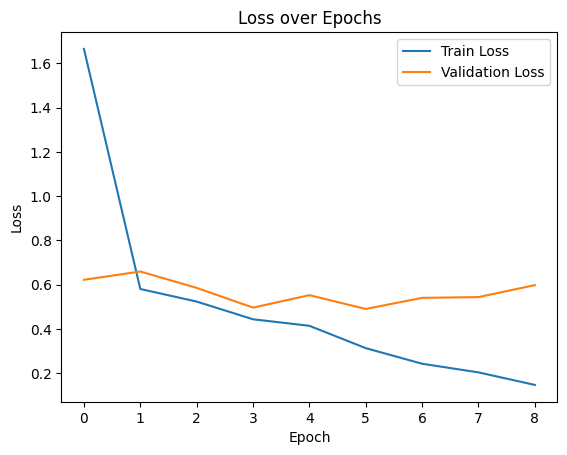

In [12]:
import matplotlib.pyplot as plt

# --- Eğitim ve Validation Loss Grafiği ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Test Dataset ---
TEST_DIR = f"{DATASET_DIRECTORY}/test"

# --- Test Data Generator (sadece normalize) ---
test_gen = ImageDataGenerator(rescale=1./255)

# --- Test Generator ---
test_generator = test_gen.flow_from_directory(
    directory=DATASET_DIRECTORY,  # Ana dizin
    classes=["test"],             # Alt klasör adı
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode=None,              # Testte label yok
    shuffle=False                 # Dosya sırasını koru
)

# --- Sınıf indeksleri kontrol ---
print("Test classes:", test_generator.class_indices)

Found 200 images belonging to 1 classes.
Test classes: {'test': 0}


## *Transfer Learning*

In [14]:
# --- Gerekli Kütüphaneler ---
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Dataset Hazırlığı ---
DATASET_DIR = "/kaggle/input/heads-or-tails-image-classification"

img_paths, labels = [], []
for cls in ["heads", "tails"]:
    folder = os.path.join(DATASET_DIR, "train", cls)
    for f in os.listdir(folder):
        if f.lower().endswith(".jpg"):
            img_paths.append(os.path.join(folder, f))
            labels.append(cls)

df = pd.DataFrame({"filename": img_paths, "label": labels})

# --- Train / Validation Split ---
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# --- ImageDataGenerator ---
IMAGE_SIZE = 224
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_dataframe(
    train_df, x_col="filename", y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="binary", batch_size=32, shuffle=True
)

val_generator = val_gen.flow_from_dataframe(
    val_df, x_col="filename", y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="binary", batch_size=32, shuffle=False
)

# --- Transfer Learning: VGG16 Base ---
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False  # Önceden eğitilmiş katmanları dondur

# --- Üst Katmanlar ---
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary Classification

model = Model(inputs=base_model.input, outputs=outputs)

# --- Compile ---
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# --- Model Eğitimi ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

# --- Model Kaydetme ---
model.save("heads_tails_vgg16.h5")


Found 640 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 189s 9s/step - accuracy: 0.5867 - loss: 2.0705 - val_accuracy: 0.7500 - val_loss: 0.4981
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 186s 9s/step - accuracy: 0.7364 - loss: 0.7478 - val_accuracy: 0.7812 - val_loss: 0.3781
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 187s 9s/step - accuracy: 0.8435 - loss: 0.3457 - val_accuracy: 0.8813 - val_loss: 0.3166
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 186s 9s/step - accuracy: 0.9081 - loss: 0.2574 - val_accuracy: 0.8625 - val_loss: 0.3050
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 186s 9s/step - accuracy: 0.9089 - loss: 0.2228 - val_accuracy: 0.8313 - val_loss: 0.3059
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 206s 10s/step - accuracy: 0.9203 - loss: 0.2046 - val_accuracy: 0.8562 - val_loss: 0.3539
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 187s 9s/step - accuracy: 0.9342 - loss: 0.1778 - val_accuracy: 0.9250 - val_los

# *End of Notebook*

## *Model Saving and Submission*
- Model saved as `.h5`: `heads_tails_vgg16.h5`
- Predictions on the test set can be generated for submission CSV.